In [2]:
from __future__ import print_function
from collections import namedtuple
from copy import deepcopy
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import traceback
import time
import yaml

import pydrake  # MUST BE BEFORE TORCH OR PYRO
from pydrake.common.eigen_geometry import Quaternion, AngleAxis, Isometry3
from pydrake.math import RollPitchYaw, RotationMatrix
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
from multiprocessing.managers import SyncManager
from tensorboardX import SummaryWriter
import networkx

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_nodes_mug_shelf import *
from scene_generation.models.probabilistic_scene_grammar_model import *
from scene_generation.models.probabilistic_scene_grammar_fitting import *

torch.set_default_tensor_type(torch.DoubleTensor)

In [71]:
seed = int(time.time()) % (2**32-1)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

# CONFIGURATION STUFF
root_node_type = MugShelf
root_node = root_node_type()
hyper_parse_tree = generate_hyperexpanded_parse_tree(root_node, max_iters=8)
guide_gvs = hyper_parse_tree.get_global_variable_store()

train_dataset = dataset_utils.ScenesDataset("../../data/mug_shelf/mug_rack_environments_human_train/")
test_dataset = dataset_utils.ScenesDataset("../../data/mug_shelf/mug_rack_environments_human_test/")
print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))

pyro.get_param_store().load("../../data/mug_shelf/icra_runs/1/param_store_initial.pyro")

for var_name in guide_gvs.keys():
    guide_gvs[var_name][0] = pyro.param(var_name + "_est",
                                        guide_gvs[var_name][0],
                                        constraint=guide_gvs[var_name][1].support)

60 training examples
40 test examples


In [ ]:
import meshcat
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.jupyter_cell()

In [77]:
# Generate a grid of sampled feasible environments from the loaded model
parse_tree = generate_unconditioned_parse_tree(root_node=root_node, initial_gvs=guide_gvs)
yaml_env = convert_tree_to_yaml_env(parse_tree)
#yaml_env = ProjectEnvironmentToFeasibility(yaml_env, base_environment_type="mug_shelf",
#                                           make_nonpenetrating=True, make_static=True)[-1]
#cam_isom = cam_quat_base = RollPitchYaw(
#    68.*np.pi/180.,
#    0.*np.pi/180,
#    80.*np.pi/180.).ToQuaternion()
#cam_trans_base = np.array([0.67, -0.11, 0.5])
#cam_tf_base = Isometry3(quaternion=cam_quat_base,
#                        translation=cam_trans_base)
#im = dataset_utils.DrawYamlEnvironmentWithBlender(yaml_env, base_environment_type="mug_shelf", cam_isom=cam_tf_base)

node_class_to_color_dict = {"MugShelf":[0., 0., 1.], "MugShelfLevel":[0., 1., 0.],
                            "MugIntermediate": [1., 0.5, 0.5], "Mug": [1., 0., 0.]}        
dataset_utils.DrawYamlEnvironment(yaml_env, base_environment_type="mug_shelf", alpha=0.95)
draw_parse_tree_meshcat(parse_tree, node_class_to_color_dict=node_class_to_color_dict, alpha=1.0)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
# Parse the entire test set
all_test_parse_trees = guess_parse_trees_batch_async(test_dataset, root_node_type=root_node_type, guide_gvs=guide_gvs.detach())

In [23]:
# Parse the outlier dataset
outlier_dataset = dataset_utils.ScenesDataset("../../data/mug_shelf/mug_rack_environments_human_adversarial.yaml")
outlier_dataset_parse_trees = guess_parse_trees_batch_async(outlier_dataset, root_node_type=root_node_type, guide_gvs=guide_gvs.detach())
outlier_dataset_parse_trees_scores = []
for parse_tree in outlier_dataset_parse_trees:
    joint_score = parse_tree.get_total_log_prob()[0]
    #latents_score = parse_tree.get_total_log_prob(include_observed=False)[0]
    outlier_dataset_parse_trees_scores.append((joint_score).item())
print(outlier_dataset_parse_trees_scores)

[-203.51087494317517, 184.79024219940442, 142.28391708402935]


In [27]:
k = 1
scores_by_node = outlier_dataset_parse_trees[k].get_total_log_prob()[1]
min_key = list(scores_by_node.keys())[0]
for key in scores_by_node.keys():
    if scores_by_node[key] < scores_by_node[min_key]:
        min_key = key
print(min_key, scores_by_node[min_key])
print(scores_by_node)
dataset_utils.DrawYamlEnvironment(outlier_dataset[k], base_environment_type="mug_shelf", alpha=0.75)
draw_parse_tree_meshcat(outlier_dataset_parse_trees[k],color_by_score=True)

<scene_generation.models.probabilistic_scene_grammar_nodes_mug_shelf.MugShelfLevel.MugProductionRule object at 0x7f50e75baeb8> tensor(-9.7788)
{<scene_generation.models.probabilistic_scene_grammar_nodes_mug_shelf.MugShelf object at 0x7f50e769d160>: tensor(-0.2635), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e7685a58>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e76dfbe0>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e76df780>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e76dfc18>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e76a8278>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nodes_dish_bin.Mug_1 object at 0x7f50e76a8358>: tensor(0.), <scene_generation.models.probabilistic_scene_grammar_nod

Text(0, 0.5, 'Relative occurance')

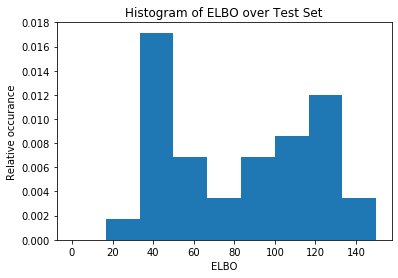

In [16]:
all_test_parse_trees_scores = []
for parse_tree in all_test_parse_trees:
    joint_score = parse_tree.get_total_log_prob()[0]
    latents_score = parse_tree.get_total_log_prob(include_observed=False)[0]
    all_test_parse_trees_scores.append((joint_score).item())
order = np.argsort(all_test_parse_trees_scores)
test_yaml_envs_in_sorted_order = [test_dataset[x] for x in order]
all_test_parse_trees_in_sorted_order = [all_test_parse_trees[x] for x in order]
all_test_parse_trees_scores_in_sorted_order = [all_test_parse_trees_scores[x] for x in order]
plt.hist(all_test_parse_trees_scores, density=True, bins=np.linspace(0., 150., 10))
plt.title("Histogram of ELBO over Test Set")
plt.xlabel("ELBO")
plt.ylabel("Relative occurance")

In [9]:
dataset_utils.DrawYamlEnvironment(test_yaml_envs_in_sorted_order[0], base_environment_type="mug_shelf", alpha=1.0)
draw_parse_tree_meshcat(all_test_parse_trees_in_sorted_order[0], color_by_score=True)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


/home/gizatt/projects/scene_generation/data/dataset_utils.py:365: DrakeDeprecationWarning: Use mutable_gravity_field().set_gravity_vector() instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  mbp.AddForceElement(UniformGravityFieldElement())
/home/gizatt/projects/scene_generation/data/dataset_utils.py:643: DrakeDeprecationWarning: '_DoPublish' is deprecated and will be removed on or around 2019-08-01. Please call 'DoPublish' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  visualizer._DoPublish(mbp_context, [])


(500,) (500, 1)


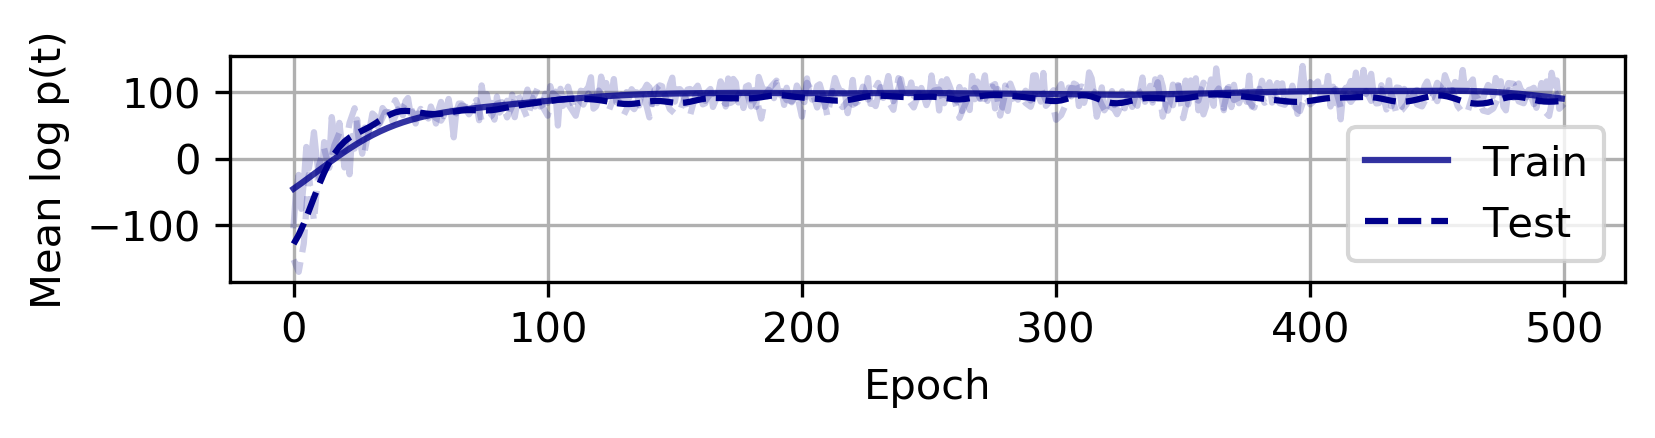

In [78]:
import scipy
import os
from scipy.ndimage import filters
import matplotlib.pyplot as plt

def load_data_from_dir(path):
    runs = os.listdir(path)
    lesioned_runs = []
    full_runs = []
    for run in runs:
        data = np.loadtxt(path + "/" + run, skiprows=1, delimiter=",")
        full_runs.append(data[:, 2])
    inds = data[:, 1]
    if len(runs) > 1:
        return inds, np.vstack(full_runs)
    else:
        return inds, np.array(full_runs).T

def apply_filtering(data, sigma):
    return filters.gaussian_filter1d(data, sigma, axis=0, mode='nearest')

def make_train_curve_plot(ax):
    inds_train, full_runs_train = load_data_from_dir("train_joint_score")
    print(inds_train.shape, full_runs_train.shape)
    full_runs_train_smoothed = apply_filtering(full_runs_train, sigma=20.)
    
    ax.plot(full_runs_train, alpha=0.2, color='darkblue')
    ax.plot(full_runs_train_smoothed, color='darkblue', alpha=0.8, label="Train")
    
    inds_test, full_runs_test = load_data_from_dir("test_joint_score")
    full_runs_test_smoothed = apply_filtering(full_runs_test, sigma=3.)
    ax.plot(inds_test, full_runs_test, alpha=0.2, color='darkblue', linestyle="--")
    ax.plot(inds_test, full_runs_test_smoothed, color='darkblue', linestyle="--", alpha=1.0, label="Test")

    ax.grid(True)
    plt.legend()
    ax.set_ylabel("Mean log p(t)")
    ax.set_xlabel("Epoch")
plt.figure(figsize=(6, 1), dpi=300)
make_train_curve_plot(plt.gca())